평가문항	상세기준
1. 자기만의 카메라앱 기능 구현을 완수하였다.	얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다.
2. 스티커 이미지를 정확한 원본 위치에 반영하였다.	정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.	얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.

In [31]:
#패키지 로딩하기
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import os

# Step 1. 스티커 구하기 or 만들기
스티커를 만들거나 구해야합니다. PPT, 포토샵 등을 이용해서 직접 만드셔도 좋습니다. 보다 간단한 방법은 픽토그램 아이콘을 이용하면 쉽게 만들 수 있습니다.

고양이는 사랑스럽기 때문에 고양이 수염 스티커를 붙여보겠습니다.

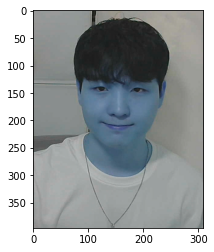

In [40]:
img_path = os.getenv("HOME") + "/aiffel/camera_sticker/images/myface.png"
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

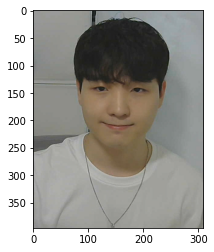

In [41]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_rgb_copy = img_rgb.copy()
plt.imshow(img_rgb)
plt.show()

# Step 2. 얼굴 검출 & 랜드마크 검출 하기
오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

## 얼굴 검출

rectangles[[(81, 98) (236, 253)]]


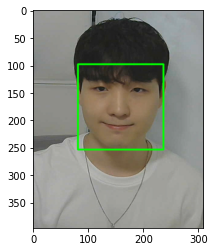

Number of faces detected: 1


In [42]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)   # 얼굴 영역을 잡아서 영역 출력

# 얼굴 영역을 저장할 리스트를 만듭니다
rectangles = []

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

    # 얼굴 영역을 리스트에 추가합니다
    rectangles.append((l, t, r, b))

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
print("Number of faces detected:", len(dlib_rects))


## 랜드마크 검출

68


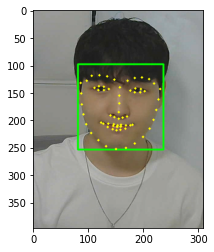

In [43]:
model_path = os.getenv('HOME')+\
'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
# 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # 얼굴에서 68개의 랜드마크를 모두 검출하면 68 출력

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기
고양이 수염이 적용 될 위치를 landmark를 사용해서 계산해 주세요.

(x,y) : (114,130)
(w,h) : (156,156)
(156, 156, 4)


<function matplotlib.pyplot.show(close=None, block=None)>

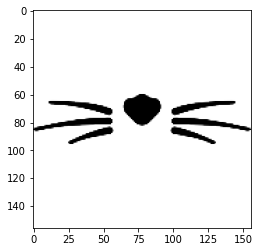

In [44]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[37][0] - 5
    y = landmark[37][1] - 8
    
    w = dlib_rect.width()
    h = dlib_rect.height()
    
    print('(x,y) : (%d,%d)' % (x, y))
    print('(w,h) : (%d,%d)' % (w, h))

sticker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)
img_sticker = cv2.resize(img_sticker, (w , h )) #스티커 크기
print(img_sticker.shape)

img_show_sticker = img_sticker.copy()
plt.imshow(img_sticker)
plt.show

In [45]:
refined_x = x - w//2 - img_sticker.shape[1]//2
refined_y = y - h//4  # 스티커의 y 좌표도 적절히 조정해줄 수 있습니다.
print(f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (-42,91)


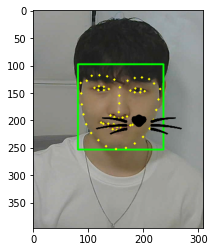

In [46]:
sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]

# 수정 부분 시작
# 스티커 이미지에서 RGB 채널만 사용
img_sticker_rgb = img_sticker[:, :, :3]

# 알파 채널만 따로 저장
sticker_alpha = img_sticker[:, :, 3] / 255.0

# 스티커 부분의 배경과 스티커를 합성
sticker_area = (1.0 - sticker_alpha[:, :, np.newaxis]) * sticker_area + sticker_alpha[:, :, np.newaxis] * img_sticker_rgb

# 합성된 이미지를 원본 이미지에 붙이기
img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = sticker_area.astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


# Step 4. 스티커 적용하기
(1) 오늘 배운 np.where 를 사용해서 스티커를 적용해 주세요.

(2) 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다. opencv 의 cv2.addWeighted() 를 참고하세요.

In [47]:
# 스티커를 붙일 영역
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: operands could not be broadcast together with shapes (156,156,4) (156,156,4) (156,156,3) 

# Step 5. 문제점 찾아보기
(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
실행 속도가 중요할까요?
스티커앱을 만들 때 정확도가 얼마나 중요할까요?

## 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?

cv2.getRotationMatrix2D와 같은 매서드를 활용해서 얼굴 방향에 맞게 스티커를 회전시켜야 한다.

### 해결방법

cv2.getRotationMatrix2D를 적용해서 회전된 행렬을 얻고, warpAffine메서드를 적용시켜 스티커가 회전한 형태로 사진에 적용시킨다.

## 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?

멀리서 촬영하면 얼굴이 상대적으로 작게 보일 수 있고, 얼굴의 각도가 바뀔 수 있다. 이로 인해 얼굴 특징과 gradient가 기존 학습 데이터와 매우 다를 가능성이 높다. 옆으로 누우면 얼굴 각도가 바뀌게 되어 기존에 학습한 얼굴과 랜드마크의 위치가 달라지기 때문이다. 그로 인해 스티커를 올바르게 적용하기 어렵다.

### 해결방법

더 많은 데이터를 수집한다. 또한 다양한 각도와 거리를 고려해서 스티커를 배치하기 위한 후처리 단계를 추가할 수 있다.

## 실행 속도가 중요할까요?

Of course! 느리면 헬조선에서 그 어플은 아무도 사용 안합니다

### 해결방법

스티커를 변경할 때 얼굴을 다시 인식시키지 않고 기존에 데이터를 활용한다. 또한 모델 최적화를 통해 성능을 향상시킬 수 있다.

## 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

무엇보다도 더 중요하다. 정확도가 낮으면 얼굴 인식을 하는 이유가 없지 않을까?

### 해결방법

좋은 얼굴 인식 알고리즘을 위해 더 많은 데이터를 수집해서 정확성을 향상시킬 수 있다. 모델 최적화를 통해 정확성을 높일 수도 있다.

## 이미지 회전

위에서 말했듯이 cv2.getRotationMatrix2D를 적용해서 회전된 행렬을 얻고, warpAffine메서드를 적용시켜 스티커가 회전한 형태로 사진에 적용시킨다.

## 빛 조건

학습을 시킬 때, 이미지가 어두운 이미지를 활용하면, 랜드마크를 올바르게 잡지 못하는 문제점이 발생하였다.. 이를 해결하기 위해서 밝기 보정 알고리즘과 같은 기술을 활용해서 보정을 진행해서 랜드마크를 진행해야 할 것 같다.

## 촬영거리

# 느낀점

학습된 모델이 아닌 직접 모델을 학습시키면서 했으면 더욱 재밌었을 것 같다. 전에 해봤던 프로젝트 중 일부가 표정 인식을 해 보았기 때문에 이번 노드는 수월했지만, 그냥 지나쳤던 부분들을 다시 확인하고 보완할 수 있었던 부분이 다른 노드들에 비해 많았던 것 같다.
스스로 성장한 부분을 정리하고 이후 학습할 노드에서 어떻게 활용되는지 살펴보아야 겠다.